In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

In [3]:
tf.enable_eager_execution()

In [24]:
def make_nn(n_inputs, n_outputs, width=32, activation=tf.nn.selu, depth=3):
    layers = [tf.keras.layers.Dense(width, activation=activation)] * depth
    net = tf.keras.Sequential(
        [tf.keras.layers.Dense(width, activation=activation, input_shape=(n_inputs,))]
        + layers +
        [tf.keras.layers.Dense(n_outputs)]
        )
    return net


class QNet():
    def __init__(self, d_states, d_actions):
        self.d_states = d_states
        self.d_actions = d_actions
        self.net = make_nn(d_states+d_actions, 1)
        self.variables = self.net.variables
        
        self.action_energy_fn = lambda a: tf.reduce_mean(self.__call__(s, a))

    def __call__(self, s, a):
        x = tf.concat([s, a], axis=1)
        return self.net(x)
    
    def choose_action(self, s):
        B = tf.shape(s)[0]
        a = langevin_dynamics(self.action_energy_fn, 200, (B, self.d_actions))
        return a
        
def langevin_dynamics(energy_fn, n, shape, step_size=1e-2, discount=0.9):
    a = tf.random.normal(shape)
    momentum = tf.zeros(shape)
    for _ in range(n):
        with tf.GradientTape() as tape:
            tape.watch(a)
            energy = energy_fn(a)
        gradient = tape.gradient(energy, a)
#         momentum = discount*momentum + gradient
        noise = tf.random.normal(a.shape)
        a += step_size * gradient + 0.1*n
    return a

In [25]:
net = QNet(8, 2)
s = tf.random.normal((1, 8))
a = tf.random.normal((1, 2))

In [26]:
print(net.choose_action(s).numpy())

[[3999.7676 4000.1274]]


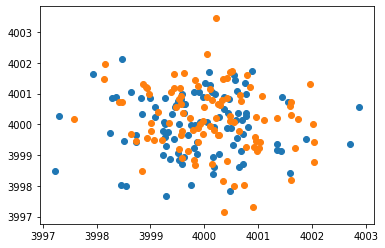

In [27]:
s = tf.random.normal((1, 8))
s = tf.concat([s for _ in range(100)], axis=0)
actions = net.choose_action(s).numpy()
plt.scatter(actions[:, 0], actions[:, 1])

s = tf.random.normal((1, 8))
s = tf.concat([s for _ in range(100)], axis=0)
actions = net.choose_action(s).numpy()
plt.scatter(actions[:, 0], actions[:, 1])

In [19]:
# now train it and see what this looks like!?